Raw image shape: (1, 240, 240)
Raw label shape: (1, 240, 240)
Raw label unique values: [0. 1. 2. 4.]
Raw label dtype: float32
Transformed image shape: torch.Size([1, 192, 192])
Transformed label shape: torch.Size([4, 192, 192])
Transformed label unique values: tensor([0., 1.])


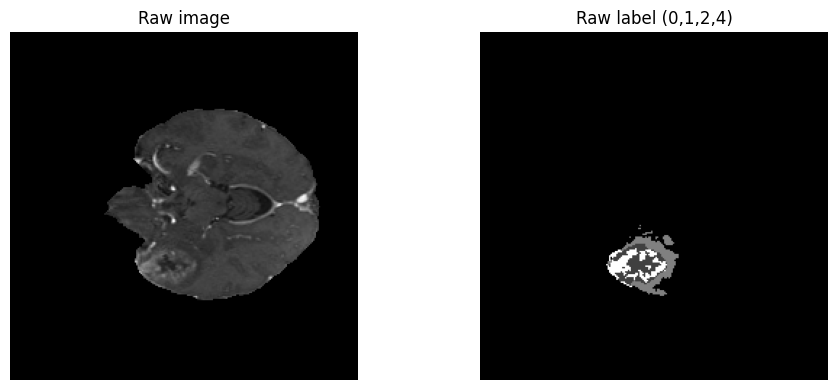

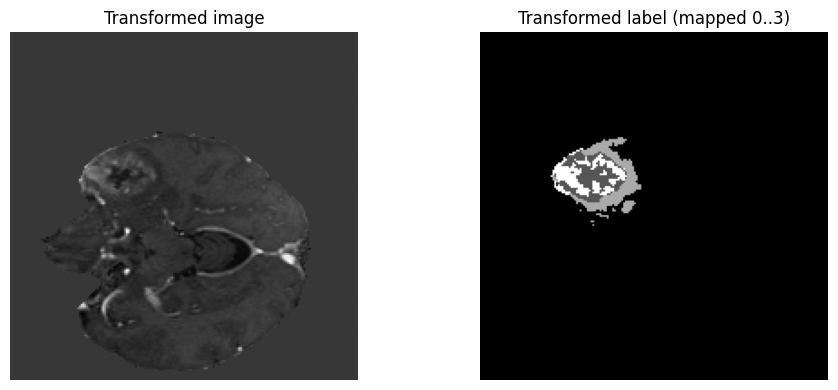

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

import torch
from monai.data import ITKReader
from monai import transforms

########################################
# 1. Paths and simple config
########################################

image_path = "../../../Segmentation_data/Training/Brains/mri_0.mhd"
label_path = "../../../Segmentation_data/Training/Labels/seg_0.mhd"

args = SimpleNamespace(
    roi_x=192,  # must be <= 240
    roi_y=192,
    RandScaleIntensityd_prob=0.1,
    RandShiftIntensityd_prob=0.1,
)

itk_reader = ITKReader()

########################################
# 2. Raw loader for inspection
########################################

raw_loader = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"], reader=itk_reader),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),  # (1, H, W)
    ]
)

sample_dict = {"image": image_path, "label": label_path}
raw_sample = raw_loader(sample_dict)

raw_img = raw_sample["image"]  # (1, H, W)
raw_lbl = raw_sample["label"]  # (1, H, W) because of EnsureChannelFirst

print("Raw image shape:", raw_img.shape)
print("Raw label shape:", raw_lbl.shape)
print("Raw label unique values:", np.unique(raw_lbl))
print("Raw label dtype:", raw_lbl.dtype)

########################################
# 3. 2D train / val transforms
########################################

# You have 4 semantic classes: values [0, 1, 2, 4]
# Map them to [0, 1, 2, 3] so we can use one-hot with 4 channels.
orig_labels = [0, 1, 2, 4]
target_labels = [0, 1, 2, 3]
num_classes = 4  # background + 3 foreground classes

train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"], reader=itk_reader),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),  # (1, H, W)

        # Map label values 0,1,2,4 -> 0,1,2,3
        transforms.MapLabelValued(
            keys="label",
            orig_labels=orig_labels,
            target_labels=target_labels,
        ),

        # Intensity normalization on image
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),

        # 2D random crop around positive / negative label regions
        transforms.RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=[args.roi_x, args.roi_y],  # 2D ROI
            pos=1,
            neg=1,
            num_samples=1,
            image_threshold=0.0,
        ),

        # 2D flips (spatial_axis refers to spatial dims after channel)
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),  # flip along H
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),  # flip along W


        # Intensity augmentation
        transforms.RandScaleIntensityd(
            keys="image", factors=0.1, prob=args.RandScaleIntensityd_prob
        ),
        transforms.RandShiftIntensityd(
            keys="image", offsets=0.1, prob=args.RandShiftIntensityd_prob
        ),

        # NOW one-hot encode labels into 4 channels
        transforms.AsDiscreted(keys="label", to_onehot=num_classes),

        transforms.ToTensord(keys=["image", "label"]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"], reader=itk_reader),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.MapLabelValued(
            keys="label",
            orig_labels=orig_labels,
            target_labels=target_labels,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.AsDiscreted(keys="label", to_onehot=num_classes),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

########################################
# 4. Apply train_transform and inspect shapes
########################################

# RandCropByPosNegLabeld with num_samples=1 returns a LIST of dicts
train_out_list = train_transform(sample_dict)
train_out = train_out_list[0]

img_t = train_out["image"]   # tensor, shape (1, roi_x, roi_y)
lbl_t = train_out["label"]   # tensor, shape (4, roi_x, roi_y)

print("Transformed image shape:", img_t.shape)
print("Transformed label shape:", lbl_t.shape)
print("Transformed label unique values:", torch.unique(lbl_t))

########################################
# 5. Visualization helpers
########################################

def show_2d(ax, img, title=""):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

########################################
# 6. Visualize BEFORE transforms
########################################

raw_img_2d = raw_img[0]  # (H, W)
raw_lbl_2d = raw_lbl[0]  # (H, W)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
show_2d(axs[0], raw_img_2d, title="Raw image")
show_2d(axs[1], raw_lbl_2d, title="Raw label (0,1,2,4)")
plt.tight_layout()
plt.savefig('./outputs/raw_image_label.png', bbox_inches='tight')
plt.show()

########################################
# 7. Visualize AFTER transforms
########################################

# img_t: (1, roi_x, roi_y)
img_np = img_t[0].cpu().numpy()  # (roi_x, roi_y)

# lbl_t: one-hot (4, roi_x, roi_y) -> argmax to get class map in [0..3]
lbl_np = torch.argmax(lbl_t, dim=0).cpu().numpy()  # (roi_x, roi_y)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
show_2d(axs[0], img_np, title="Transformed image")
show_2d(axs[1], lbl_np, title="Transformed label (mapped 0..3)")
plt.tight_layout()
plt.savefig('./outputs/transformed_image_label.png', bbox_inches='tight')
plt.show()


In [4]:
import os
import glob
import numpy as np
import pandas as pd
from monai.transforms import LoadImaged, EnsureChannelFirstd, Compose
from monai.data import ITKReader
from tqdm import tqdm

train_dir = "../../../Segmentation_data/Training/"
test_dir  = "../../../Segmentation_data/Testing/"

reader = ITKReader()

# Shared loader for image + label
loader = Compose([
    LoadImaged(keys=["image", "label"], reader=reader),
    EnsureChannelFirstd(keys=["image", "label"]),
])


def collect_pairs(root_dir):
    """Returns list of dicts: [{'image': path, 'label': path, 'case_id': id}, ...]"""
    img_paths = sorted(glob.glob(os.path.join(root_dir, "Brains", "mri_*.mhd")))
    pairs = []
    for img_path in img_paths:
        case_id = os.path.basename(img_path).split("_")[-1].replace(".mhd", "")
        label_path = os.path.join(root_dir, "Labels", f"seg_{case_id}.mhd")
        if os.path.exists(label_path):
            pairs.append({"image": img_path, "label": label_path, "case_id": case_id})
        else:
            print(f"[WARNING] Missing label for case {case_id}")
    return pairs


def compute_stats(split_name, root_dir):
    print(f"\n===== Processing {split_name} =====")

    pairs = collect_pairs(root_dir)
    stats = []

    for item in tqdm(pairs):
        try:
            sample = loader({"image": item["image"], "label": item["label"]})
            img = sample["image"]  # shape: (1, H, W)
            lbl = sample["label"]  # shape: (1, H, W)

            img = img[0]  # (H, W)
            lbl = lbl[0]  # (H, W)

            H, W = img.shape
            nonzero = img[img > 0]

            # Label stats
            unique_labels, counts = np.unique(lbl, return_counts=True)
            label_dist = dict(zip(unique_labels.tolist(), counts.tolist()))

            stats.append({
                "case_id": item["case_id"],
                "height": H,
                "width": W,
                "intensity_mean": float(nonzero.mean()) if nonzero.size > 0 else 0,
                "intensity_std": float(nonzero.std()) if nonzero.size > 0 else 0,
                "intensity_min": float(img.min()),
                "intensity_max": float(img.max()),
                "total_pixels": img.size,
                "label_values": unique_labels.tolist(),
                "label_counts": label_dist,
            })

        except Exception as e:
            print(f"[ERROR] Failed on {item['case_id']}: {e}")

    return stats


# ---- Compute Stats ----
train_stats = compute_stats("Training", train_dir)
test_stats = compute_stats("Testing",   test_dir)

# ---- Convert to DataFrame ----
def stats_to_df(stats_list):
    rows = []
    for s in stats_list:
        row = {
            "case_id": s["case_id"],
            "H": s["height"],
            "W": s["width"],
            "int_mean": s["intensity_mean"],
            "int_std": s["intensity_std"],
            "int_min": s["intensity_min"],
            "int_max": s["intensity_max"],
        }

        # Expand label counts into columns: class_0, class_1,...
        for cls, count in s["label_counts"].items():
            row[f"class_{int(cls)}_px"] = count
            row[f"class_{int(cls)}_pct"] = count / s["total_pixels"] * 100

        rows.append(row)
    return pd.DataFrame(rows)


train_df = stats_to_df(train_stats)
test_df  = stats_to_df(test_stats)

print("\n=== Training Set Statistics ===")
display(train_df)

print("\n=== Testing Set Statistics ===")
display(test_df)

# Save CSVs
train_df.to_csv("training_dataset_stats.csv", index=False)
test_df.to_csv("testing_dataset_stats.csv", index=False)

print("\nSaved:")
print(" - training_dataset_stats.csv")
print(" - testing_dataset_stats.csv")



===== Processing Training =====


100%|██████████| 3360/3360 [05:11<00:00, 10.78it/s]



===== Processing Testing =====


100%|██████████| 380/380 [01:12<00:00,  5.21it/s]


=== Training Set Statistics ===


,case_id,H,W,int_mean,int_std,int_min,int_max,class_0_px,class_0_pct,class_1_px,class_1_pct,class_2_px,class_2_pct,class_4_px,class_4_pct
0,0,240,240,384.901764,114.769058,0.0,1542.0,56280,97.708333,440.0,0.763889,500.0,0.868056,380.0,0.659722
1,1,240,240,387.210144,114.570396,0.0,1684.0,56320,97.777778,423.0,0.734375,479.0,0.831597,378.0,0.656250
2,10,240,240,401.980377,102.470001,0.0,1624.0,56735,98.498264,176.0,0.305556,309.0,0.536458,380.0,0.659722
3,1008,240,240,69.552628,20.558502,0.0,265.0,54556,94.715278,317.0,0.550347,919.0,1.595486,1808.0,3.138889
4,10080,240,240,317.115417,90.202484,0.0,1264.0,56997,98.953125,227.0,0.394097,128.0,0.222222,248.0,0.430556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9927,240,240,75.589142,17.394548,0.0,163.0,57590,99.982639,NaN,NaN,10.0,0.017361,NaN,NaN
3356,9928,240,240,75.902016,17.278973,0.0,173.0,57580,99.965278,NaN,NaN,20.0,0.034722,NaN,NaN
3357,9929,240,240,76.219368,17.240669,0.0,181.0,57580,99.965278,NaN,NaN,20.0,0.034722,NaN,NaN
3358,9930,240,240,76.403542,16.968699,0.0,150.0,57581,99.967014,NaN,NaN,19.0,0.032986,NaN,NaN



=== Testing Set Statistics ===


,case_id,H,W,int_mean,int_std,int_min,int_max,class_0_px,class_0_pct,class_1_px,class_1_pct,class_2_px,class_2_pct,class_4_px,class_4_pct
0,32088,240,240,379.376129,94.361763,0.0,1165.0,56571,98.213542,281.0,0.487847,469.0,0.814236,279.0,0.484375
1,32089,240,240,382.690918,95.775192,0.0,1254.0,56442,97.989583,346.0,0.600694,479.0,0.831597,333.0,0.578125
2,32090,240,240,383.827606,96.107544,0.0,1178.0,56316,97.770833,409.0,0.710069,490.0,0.850694,385.0,0.668403
3,32091,240,240,385.509888,98.021500,0.0,1207.0,56233,97.626736,506.0,0.878472,488.0,0.847222,373.0,0.647569
4,32092,240,240,388.944855,100.945808,0.0,1200.0,56144,97.472222,557.0,0.967014,486.0,0.843750,413.0,0.717014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,35127,240,240,383.761566,111.233376,0.0,1393.0,55192,95.819444,364.0,0.631944,1710.0,2.968750,334.0,0.579861
376,35128,240,240,381.399078,107.990158,0.0,1350.0,55210,95.850694,424.0,0.736111,1637.0,2.842014,329.0,0.571181
377,35129,240,240,381.037018,107.616188,0.0,1249.0,55191,95.817708,471.0,0.817708,1615.0,2.803819,323.0,0.560764
378,35130,240,240,380.168762,107.807327,0.0,1347.0,55076,95.618056,511.0,0.887153,1689.0,2.932292,324.0,0.562500



Saved:
 - training_dataset_stats.csv
 - testing_dataset_stats.csv


In [7]:
import numpy as np
import pandas as pd

def quick_split_summary(stats_list, split_name="Training"):
    n = len(stats_list)
    heights = [s["height"] for s in stats_list]
    widths  = [s["width"] for s in stats_list]

    print(f"\n===== {split_name} Summary =====")
    print(f"Num samples : {n}")
    print(f"Height (min/med/max): {min(heights)} / {np.median(heights)} / {max(heights)}")
    print(f"Width  (min/med/max): {min(widths)} / {np.median(widths)} / {max(widths)}")

    # build per-class image-level counts (how many images contain each label)
    all_classes = sorted({int(c) for s in stats_list for c in s["label_values"]})
    rows = []
    for cls in all_classes:
        num_images_with_cls = sum(1 for s in stats_list if cls in s["label_values"])
        rows.append({
            "label": cls,
            "num_images_with_label": num_images_with_cls,
            "fraction_of_images_%": 100.0 * num_images_with_cls / n,
        })

    df = pd.DataFrame(rows)
    print(f"\nPer-class IMAGE distribution (presence, not pixels):")
    display(df)
    return df

train_class_df = quick_split_summary(train_stats, "Training")
test_class_df  = quick_split_summary(test_stats,  "Testing")



===== Training Summary =====
Num samples : 3360
Height (min/med/max): 240 / 240.0 / 240
Width  (min/med/max): 240 / 240.0 / 240

Per-class IMAGE distribution (presence, not pixels):


,label,num_images_with_label,fraction_of_images_%
0,0,3360,100.000000
1,1,2023,60.208333
2,2,2945,87.648810
3,4,2174,64.702381



===== Testing Summary =====
Num samples : 380
Height (min/med/max): 240 / 240.0 / 240
Width  (min/med/max): 240 / 240.0 / 240

Per-class IMAGE distribution (presence, not pixels):


,label,num_images_with_label,fraction_of_images_%
0,0,380,100.000000
1,1,211,55.526316
2,2,338,88.947368
3,4,211,55.526316
